In [1]:
from PIL import Image
import numpy as np
import glob
from keras.layers import Input,Activation, BatchNormalization, Conv2D,MaxPooling2D,Softmax,Dropout
from keras.models import Model,load_model
from keras.initializers import glorot_uniform
import keras.backend as K
K.set_image_data_format('channels_last')
from keras.preprocessing import image
from matplotlib.pyplot import imshow
%matplotlib inline

In [2]:
def processOneLabel(y_in):
    
        
    m={
    "P" : [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    "B" : [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    "R" : [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    "N" : [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
    "K" : [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
    "Q" : [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
    "p" : [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
    "b" : [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
    "r" : [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
    "n" : [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
    "k" : [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
    "q" : [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]    
    }    
    
    
    y = np.zeros((8,8,13))   
    digitCode = [1,0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
    
    i = 0
    j=0
    for a in y_in:
        if a != '-':
            if a.isdigit():
                for t in range(j, j + int(a)):
                    y[i,t,:] = digitCode
                j += int(a)
            else:                
                y[i,j,:] = m[a]
                j += 1
        else:
            i += 1
            j=0
    
    return y  

In [3]:
def processLabels(Y_orig):
    
    y_train = np.zeros((len(Y_orig),8,8,13))
    
    i=0
    for y_in in Y_orig:
        y_train[i,:,:,:] = processOneLabel(y_in)
        i+=1
    
    return y_train        

In [4]:
def image_generator(imagePath, size):
    
    imageList  = glob.glob(imagePath) 
    np.random.shuffle(imageList)
    num = len(imageList)
        
    i=0
    while  i < num :
        if num-i >size:
            yield imageList[i:i+ size]
            i += size   
        else:
            yield imageList[i:num]
            i = num

In [5]:
def getData(smallImageList):
        
    y = [fname[18:-5] for fname in smallImageList]  
    x = np.array([np.array(Image.open(fname)) for fname in smallImageList]) 
    
    
    x = x/255.
    y = processLabels(y)
        
    return x,y  

In [6]:
def getSingleFEN(yhat):
    
    m={
    0 : "0", #No Piece
    1 : "P", #White Pawn
    2 : "B", #White Bishop
    3 : "R", #White Rook
    4 : "N", #White Knight
    5 : "K", #White King
    6 : "Q", #White Queen
    7 : "p", #Black pawn
    8 : "b", #Black bishop 
    9 : "r", #Black rook
    10 : "n", #Black Knight
    11 : "k", #Black King
    12 : "q"  #Black Queen
    } 
    
    a =[]
    digit =0
    for i in range(8):
        for j in range(8):
            res = m[yhat[8*i +j]]
            if res != "0":
                if digit > 0:
                    a.append(str(digit))
                    digit=0
                a.append(res) 
            else:
                digit += 1
        if digit > 0:
            a.append(str(digit))
            digit=0
        a.append("-")         
    
    
    return "".join(a[:-1]) 

In [7]:
def chessModel(input_shape): 
    #input_shape -- shape of the images of the dataset(height, width, channels) as a tuple.   
    
    X_input = Input(input_shape)    
    
    X = Conv2D(6, (3,3), strides = (1, 1), name = 'conv0',kernel_initializer = glorot_uniform())(X_input)
    X = BatchNormalization(axis = 3, name = 'bn0')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((2, 2), name='max_pool0')(X)
        
    
    X = Conv2D(12, (4,4), strides = (1, 1), name = 'conv1',kernel_initializer = glorot_uniform())(X)
    X = BatchNormalization(axis = 3, name = 'bn1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((2, 2), name='max_pool1')(X)
        
    
    X = Conv2D(16, (3,3), strides = (1, 1), name = 'conv2',kernel_initializer = glorot_uniform())(X)
    X = BatchNormalization(axis = 3, name = 'bn2')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((2, 2), name='max_pool2')(X)
    
    
    X = Conv2D(20, (4,4), strides = (1, 1), name = 'conv3',kernel_initializer = glorot_uniform())(X)
    X = BatchNormalization(axis = 3, name = 'bn3')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((2, 2), name='max_pool3')(X)
    
    
    X = Conv2D(24, (3,3), strides = (1, 1), name = 'conv4',kernel_initializer = glorot_uniform())(X)
    X = BatchNormalization(axis = 3, name = 'bn4')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((2, 2), name='max_pool4')(X)
    
    
    
    X = Conv2D(28, (3,3), strides = (1, 1), name = 'conv5',kernel_initializer = glorot_uniform())(X)
    X = BatchNormalization(axis = 3, name = 'bn5')(X)
    X = Activation('relu')(X)
        
    X = Conv2D(50, (1,1), strides = (1, 1), name = 'conv6',kernel_initializer = glorot_uniform())(X)
    X = BatchNormalization(axis = 3, name = 'bn6')(X)
    X = Activation('relu')(X)
       
    
    X = Conv2D(50, (1,1), strides = (1, 1), name = 'conv7',kernel_initializer = glorot_uniform())(X)
    X = BatchNormalization(axis = 3, name = 'bn7')(X)
    X = Activation('relu')(X)
    #X = Dropout(0.2)(X)
    
    
    X = Conv2D(13, (1,1), strides = (1, 1), name = 'conv8',kernel_initializer = glorot_uniform())(X)
    X = BatchNormalization(axis = 3, name = 'bn8')(X)    
    X = Softmax(axis=-1)(X)    
    
    
    model = Model(inputs = X_input, outputs = X, name='chessModel')     
      
    return model

In [8]:
def loss(y_true, y_pred): 
    
    """
    100000 images of a randomly generated chess positions of 5-15 pieces (2 kings and 3-13 pawns/pieces)
    Pieces were generated with the following probability distribution:

    30% for Pawn
    20% for Bishop
    20% for Knight
    20% for Rook
    10% for Queen

    2 Kings are guaranteed to be on the board.
    """
    
    #The inverse of expectation : assuming average 10 pieces on an image
    weights = [1/(64-10),
               1/(4*0.3),
               1/(4*0.2),
               1/(4*0.2),
               1/(4*0.2),
               1,
               1/(4*0.1),
               1/(4*0.3),
               1/(4*0.2),              
               1/(4*0.2),
               1/(4*0.2),
               1,
               1/(4*0.1)]
   
    loss = y_true * K.log(y_pred) * weights
    loss = -K.sum(loss, -1)
    return loss

In [9]:
model = chessModel(input_shape = (400,400,3))
model.compile(optimizer='adam', loss=loss,metrics=['accuracy'])

In [10]:
trainPath = "ChessImages/train/*.jpeg"
for epoch in range(5):
    for imgList in image_generator(trainPath,32):
        X_train,Y_train = getData(imgList)
        model.fit(X_train, Y_train, batch_size=32, epochs=epoch+1, initial_epoch=epoch)

1/1 [==============================] - 0s 0s/step - loss: 0.5648 - accuracy: 0.2803


1/1 [==============================] - 0s 8ms/step - loss: 0.4686 - accuracy: 0.2788


1/1 [==============================] - 0s 0s/step - loss: 0.4848 - accuracy: 0.3198


1/1 [==============================] - 0s 0s/step - loss: 0.4039 - accuracy: 0.3545


1/1 [==============================] - 0s 0s/step - loss: 0.3118 - accuracy: 0.4258


1/1 [==============================] - 0s 0s/step - loss: 0.2209 - accuracy: 0.5322


1/1 [==============================] - 0s 0s/step - loss: 0.1860 - accuracy: 0.6099


1/1 [==============================] - 0s 0s/step - loss: 0.1761 - accuracy: 0.6709


1/1 [==============================] - 0s 0s/step - loss: 0.1626 - accuracy: 0.7124


1/1 [==============================] - 0s 0s/step - loss: 0.0898 - accuracy: 0.7837


1/1 [==============================] - 0s 0s/step - loss: 0.0691 - accuracy: 0.8232


1/1 [==============================] - 0s 2ms/step - loss: 0.0680 - accuracy: 0.8315


1/1 [==============================] - 0s 0s/step - loss: 0.0707 - accuracy: 0.8491
Epoch 2/2
1/1 [==============================] - 0s 0s/step - loss: 0.0552 - accuracy: 0.8457
Epoch 2/2
1/1 [==============================] - 0s 2ms/step - loss: 0.0742 - accuracy: 0.8628
Epoch 2/2
1/1 [==============================] - 0s 0s/step - loss: 0.0349 - accuracy: 0.8638
Epoch 2/2
1/1 [==============================] - 0s 2ms/step - loss: 0.0723 - accuracy: 0.8418
Epoch 2/2
1/1 [==============================] - 0s 0s/step - loss: 0.0517 - accuracy: 0.8623
Epoch 2/2
1/1 [==============================] - 0s 0s/step - loss: 0.0545 - accuracy: 0.8550
Epoch 2/2
1/1 [==============================] - 0s 0s/step - loss: 0.0566 - accuracy: 0.8486
Epoch 2/2
1/1 [==============================] - 0s 0s/step - loss: 0.0348 - accuracy: 0.8521
Epoch 2/2
1/1 [==============================] - 0s 0s/step - loss: 0.0716 - accuracy: 0.8579
Epoch 2/2
1/1 [==============================] - 0s 2ms/step - loss:

1/1 [==============================] - 0s 0s/step - loss: 0.0492 - accuracy: 0.8794
Epoch 2/2
1/1 [==============================] - 0s 0s/step - loss: 0.0451 - accuracy: 0.8687
Epoch 2/2
1/1 [==============================] - 0s 0s/step - loss: 0.0466 - accuracy: 0.8662
Epoch 2/2
1/1 [==============================] - 0s 0s/step - loss: 0.0467 - accuracy: 0.8745
Epoch 2/2
1/1 [==============================] - 0s 0s/step - loss: 0.0493 - accuracy: 0.8574
Epoch 2/2
1/1 [==============================] - 0s 0s/step - loss: 0.0573 - accuracy: 0.8633
Epoch 2/2
1/1 [==============================] - 0s 0s/step - loss: 0.0593 - accuracy: 0.8662
Epoch 2/2
1/1 [==============================] - 0s 0s/step - loss: 0.0502 - accuracy: 0.8638
Epoch 2/2
1/1 [==============================] - 0s 8ms/step - loss: 0.0545 - accuracy: 0.8633
Epoch 2/2
1/1 [==============================] - 0s 2ms/step - loss: 0.0469 - accuracy: 0.8506
Epoch 2/2
1/1 [==============================] - 0s 8ms/step - loss:

Epoch 2/2
1/1 [==============================] - 0s 0s/step - loss: 0.0553 - accuracy: 0.8696
Epoch 2/2
1/1 [==============================] - 0s 0s/step - loss: 0.0576 - accuracy: 0.8789
Epoch 2/2
1/1 [==============================] - 0s 0s/step - loss: 0.0444 - accuracy: 0.8706
Epoch 2/2
1/1 [==============================] - 0s 2ms/step - loss: 0.0501 - accuracy: 0.8721
Epoch 2/2
1/1 [==============================] - 0s 0s/step - loss: 0.0869 - accuracy: 0.8711
Epoch 2/2
1/1 [==============================] - 0s 0s/step - loss: 0.0551 - accuracy: 0.8745
Epoch 2/2
1/1 [==============================] - 0s 0s/step - loss: 0.0605 - accuracy: 0.8730
Epoch 2/2
1/1 [==============================] - 0s 16ms/step - loss: 0.0502 - accuracy: 0.8799
Epoch 2/2
1/1 [==============================] - 0s 0s/step - loss: 0.0635 - accuracy: 0.8682
Epoch 2/2
1/1 [==============================] - 0s 0s/step - loss: 0.0595 - accuracy: 0.8823
Epoch 2/2
1/1 [==============================] - 0s 0s/st

1/1 [==============================] - 0s 2ms/step - loss: 0.0535 - accuracy: 0.8604
Epoch 2/2
1/1 [==============================] - 0s 0s/step - loss: 0.0559 - accuracy: 0.8862
Epoch 2/2
1/1 [==============================] - 0s 0s/step - loss: 0.0416 - accuracy: 0.8828
Epoch 2/2
1/1 [==============================] - 0s 0s/step - loss: 0.0542 - accuracy: 0.8857
Epoch 2/2
1/1 [==============================] - 0s 8ms/step - loss: 0.0626 - accuracy: 0.8735
Epoch 2/2
1/1 [==============================] - 0s 0s/step - loss: 0.0338 - accuracy: 0.8789
Epoch 2/2
1/1 [==============================] - 0s 0s/step - loss: 0.0580 - accuracy: 0.8735
Epoch 2/2
1/1 [==============================] - 0s 0s/step - loss: 0.0612 - accuracy: 0.8936
Epoch 2/2
1/1 [==============================] - 0s 2ms/step - loss: 0.0519 - accuracy: 0.8721
Epoch 2/2
1/1 [==============================] - 0s 0s/step - loss: 0.0345 - accuracy: 0.8892
Epoch 2/2
1/1 [==============================] - 0s 0s/step - loss:

1/1 [==============================] - 0s 0s/step - loss: 0.0484 - accuracy: 0.8984
Epoch 2/2
1/1 [==============================] - 0s 0s/step - loss: 0.0468 - accuracy: 0.8857
Epoch 2/2
1/1 [==============================] - 0s 0s/step - loss: 0.0487 - accuracy: 0.8916
Epoch 2/2
1/1 [==============================] - 0s 0s/step - loss: 0.0395 - accuracy: 0.8931
Epoch 2/2
1/1 [==============================] - 0s 0s/step - loss: 0.0472 - accuracy: 0.8818
Epoch 2/2
1/1 [==============================] - 0s 0s/step - loss: 0.0404 - accuracy: 0.8955
Epoch 2/2
1/1 [==============================] - 0s 8ms/step - loss: 0.0531 - accuracy: 0.8828
Epoch 2/2
1/1 [==============================] - 0s 16ms/step - loss: 0.0451 - accuracy: 0.8901
Epoch 2/2
1/1 [==============================] - 0s 0s/step - loss: 0.0530 - accuracy: 0.8740
Epoch 2/2
1/1 [==============================] - 0s 8ms/step - loss: 0.0494 - accuracy: 0.8896
Epoch 2/2
1/1 [==============================] - 0s 0s/step - loss

Epoch 2/2
1/1 [==============================] - 0s 0s/step - loss: 0.0425 - accuracy: 0.9043
Epoch 2/2
1/1 [==============================] - 0s 8ms/step - loss: 0.0613 - accuracy: 0.8955
Epoch 2/2
1/1 [==============================] - 0s 0s/step - loss: 0.0398 - accuracy: 0.8960
Epoch 2/2
1/1 [==============================] - 0s 0s/step - loss: 0.0319 - accuracy: 0.9019
Epoch 2/2
1/1 [==============================] - 0s 0s/step - loss: 0.0407 - accuracy: 0.9077
Epoch 2/2
1/1 [==============================] - 0s 8ms/step - loss: 0.0482 - accuracy: 0.8979
Epoch 2/2
1/1 [==============================] - 0s 8ms/step - loss: 0.0460 - accuracy: 0.8965
Epoch 2/2
1/1 [==============================] - 0s 0s/step - loss: 0.0478 - accuracy: 0.8916
Epoch 2/2
1/1 [==============================] - 0s 0s/step - loss: 0.0523 - accuracy: 0.8892
Epoch 2/2
1/1 [==============================] - 0s 0s/step - loss: 0.0325 - accuracy: 0.9082
Epoch 2/2
1/1 [==============================] - 0s 0s/st

Epoch 2/2
1/1 [==============================] - 0s 0s/step - loss: 0.0461 - accuracy: 0.8921
Epoch 2/2
1/1 [==============================] - 0s 0s/step - loss: 0.0328 - accuracy: 0.8887
Epoch 2/2
1/1 [==============================] - 0s 2ms/step - loss: 0.0357 - accuracy: 0.9121
Epoch 2/2
1/1 [==============================] - 0s 16ms/step - loss: 0.0504 - accuracy: 0.8955
Epoch 2/2
1/1 [==============================] - 0s 0s/step - loss: 0.0351 - accuracy: 0.8989
Epoch 2/2
1/1 [==============================] - 0s 0s/step - loss: 0.0236 - accuracy: 0.9077
Epoch 2/2
1/1 [==============================] - 0s 0s/step - loss: 0.0335 - accuracy: 0.9038
Epoch 2/2
1/1 [==============================] - 0s 0s/step - loss: 0.0436 - accuracy: 0.8901
Epoch 2/2
1/1 [==============================] - 0s 0s/step - loss: 0.0487 - accuracy: 0.9004
Epoch 2/2
1/1 [==============================] - 0s 0s/step - loss: 0.0410 - accuracy: 0.9077
Epoch 2/2
1/1 [==============================] - 0s 0s/st

1/1 [==============================] - 0s 0s/step - loss: 0.0315 - accuracy: 0.9243
Epoch 2/2
1/1 [==============================] - 0s 2ms/step - loss: 0.0378 - accuracy: 0.9097
Epoch 2/2
1/1 [==============================] - 0s 0s/step - loss: 0.0467 - accuracy: 0.9111
Epoch 2/2
1/1 [==============================] - 0s 8ms/step - loss: 0.0413 - accuracy: 0.9004
Epoch 2/2
1/1 [==============================] - 0s 0s/step - loss: 0.0332 - accuracy: 0.9111
Epoch 2/2
1/1 [==============================] - 0s 0s/step - loss: 0.0269 - accuracy: 0.9087
Epoch 2/2
1/1 [==============================] - 0s 0s/step - loss: 0.0338 - accuracy: 0.9282
Epoch 2/2
1/1 [==============================] - 0s 8ms/step - loss: 0.0297 - accuracy: 0.9106
Epoch 2/2
1/1 [==============================] - 0s 0s/step - loss: 0.0363 - accuracy: 0.9067
Epoch 2/2
1/1 [==============================] - 0s 16ms/step - loss: 0.0341 - accuracy: 0.9126
Epoch 2/2
1/1 [==============================] - 0s 0s/step - los

1/1 [==============================] - 0s 0s/step - loss: 0.0346 - accuracy: 0.9312
Epoch 2/2
1/1 [==============================] - 0s 16ms/step - loss: 0.0289 - accuracy: 0.9243
Epoch 2/2
1/1 [==============================] - 0s 16ms/step - loss: 0.0390 - accuracy: 0.9199
Epoch 2/2
1/1 [==============================] - 0s 0s/step - loss: 0.0324 - accuracy: 0.9136
Epoch 2/2
1/1 [==============================] - 0s 0s/step - loss: 0.0292 - accuracy: 0.9189
Epoch 2/2
1/1 [==============================] - 0s 0s/step - loss: 0.0370 - accuracy: 0.9229
Epoch 2/2
1/1 [==============================] - 0s 0s/step - loss: 0.0311 - accuracy: 0.9189
Epoch 2/2
1/1 [==============================] - 0s 0s/step - loss: 0.0390 - accuracy: 0.9150
Epoch 2/2
1/1 [==============================] - 0s 0s/step - loss: 0.0460 - accuracy: 0.9160
Epoch 2/2
1/1 [==============================] - 0s 8ms/step - loss: 0.0351 - accuracy: 0.9160
Epoch 2/2
1/1 [==============================] - 0s 0s/step - los

Epoch 2/2
1/1 [==============================] - 0s 8ms/step - loss: 0.0346 - accuracy: 0.9292
Epoch 2/2
1/1 [==============================] - 0s 0s/step - loss: 0.0390 - accuracy: 0.9302
Epoch 2/2
1/1 [==============================] - 0s 0s/step - loss: 0.0216 - accuracy: 0.9302
Epoch 2/2
1/1 [==============================] - 0s 0s/step - loss: 0.0357 - accuracy: 0.9429
Epoch 2/2
1/1 [==============================] - 0s 0s/step - loss: 0.0229 - accuracy: 0.9287
Epoch 2/2
1/1 [==============================] - 0s 0s/step - loss: 0.0236 - accuracy: 0.9277
Epoch 2/2
1/1 [==============================] - 0s 0s/step - loss: 0.0283 - accuracy: 0.9268
Epoch 2/2
1/1 [==============================] - 0s 0s/step - loss: 0.0275 - accuracy: 0.9399
Epoch 2/2
1/1 [==============================] - 0s 0s/step - loss: 0.0365 - accuracy: 0.9258
Epoch 2/2
1/1 [==============================] - 0s 0s/step - loss: 0.0241 - accuracy: 0.9302
Epoch 2/2
1/1 [==============================] - 0s 0s/step

Epoch 2/2
1/1 [==============================] - 0s 16ms/step - loss: 0.0241 - accuracy: 0.9360
Epoch 2/2
1/1 [==============================] - 0s 0s/step - loss: 0.0232 - accuracy: 0.9321
Epoch 2/2
1/1 [==============================] - 0s 0s/step - loss: 0.0261 - accuracy: 0.9287
Epoch 2/2
1/1 [==============================] - 0s 8ms/step - loss: 0.0292 - accuracy: 0.9424
Epoch 2/2
1/1 [==============================] - 0s 0s/step - loss: 0.0382 - accuracy: 0.9370
Epoch 2/2
1/1 [==============================] - 0s 0s/step - loss: 0.0346 - accuracy: 0.9409
Epoch 2/2
1/1 [==============================] - 0s 0s/step - loss: 0.0233 - accuracy: 0.9316
Epoch 2/2
1/1 [==============================] - 0s 0s/step - loss: 0.0226 - accuracy: 0.9419
Epoch 2/2
1/1 [==============================] - 0s 0s/step - loss: 0.0293 - accuracy: 0.9331
Epoch 2/2
1/1 [==============================] - 0s 0s/step - loss: 0.0304 - accuracy: 0.9517
Epoch 2/2
1/1 [==============================] - 0s 0s/st

1/1 [==============================] - 0s 0s/step - loss: 0.0194 - accuracy: 0.9336
Epoch 2/2
1/1 [==============================] - 0s 0s/step - loss: 0.0300 - accuracy: 0.9351
Epoch 2/2
1/1 [==============================] - 0s 0s/step - loss: 0.0181 - accuracy: 0.9478
Epoch 2/2
1/1 [==============================] - 0s 0s/step - loss: 0.0320 - accuracy: 0.9263
Epoch 2/2
1/1 [==============================] - 0s 8ms/step - loss: 0.0316 - accuracy: 0.9355
Epoch 2/2
1/1 [==============================] - 0s 0s/step - loss: 0.0225 - accuracy: 0.9380
Epoch 2/2
1/1 [==============================] - 0s 0s/step - loss: 0.0233 - accuracy: 0.9497
Epoch 2/2
1/1 [==============================] - 0s 0s/step - loss: 0.0220 - accuracy: 0.9448
Epoch 2/2
1/1 [==============================] - 0s 0s/step - loss: 0.0224 - accuracy: 0.9375
Epoch 2/2
1/1 [==============================] - 0s 11us/step - loss: 0.0166 - accuracy: 0.9468
Epoch 2/2
1/1 [==============================] - 0s 2ms/step - loss

1/1 [==============================] - 0s 0s/step - loss: 0.0238 - accuracy: 0.9443
Epoch 2/2
1/1 [==============================] - 0s 0s/step - loss: 0.0204 - accuracy: 0.9438
Epoch 2/2
1/1 [==============================] - 0s 0s/step - loss: 0.0345 - accuracy: 0.9424
Epoch 2/2
1/1 [==============================] - 0s 0s/step - loss: 0.0226 - accuracy: 0.9448
Epoch 2/2
1/1 [==============================] - 0s 8ms/step - loss: 0.0216 - accuracy: 0.9443
Epoch 2/2
1/1 [==============================] - 0s 16ms/step - loss: 0.0136 - accuracy: 0.9448
Epoch 2/2
1/1 [==============================] - 0s 0s/step - loss: 0.0234 - accuracy: 0.9434
Epoch 2/2
1/1 [==============================] - 0s 8ms/step - loss: 0.0315 - accuracy: 0.9512
Epoch 2/2
1/1 [==============================] - 0s 8ms/step - loss: 0.0331 - accuracy: 0.9409
Epoch 2/2
1/1 [==============================] - 0s 0s/step - loss: 0.0335 - accuracy: 0.9463
Epoch 2/2
1/1 [==============================] - 0s 8ms/step - lo

Epoch 2/2
1/1 [==============================] - 0s 0s/step - loss: 0.0313 - accuracy: 0.9487
Epoch 2/2
1/1 [==============================] - 0s 8ms/step - loss: 0.0276 - accuracy: 0.9536
Epoch 2/2
1/1 [==============================] - 0s 0s/step - loss: 0.0184 - accuracy: 0.9497
Epoch 2/2
1/1 [==============================] - 0s 0s/step - loss: 0.0242 - accuracy: 0.9458
Epoch 2/2
1/1 [==============================] - 0s 0s/step - loss: 0.0221 - accuracy: 0.9541
Epoch 2/2
1/1 [==============================] - 0s 0s/step - loss: 0.0121 - accuracy: 0.9575
Epoch 2/2
1/1 [==============================] - 0s 0s/step - loss: 0.0255 - accuracy: 0.9448
Epoch 2/2
1/1 [==============================] - 0s 0s/step - loss: 0.0242 - accuracy: 0.9468
Epoch 2/2
1/1 [==============================] - 0s 0s/step - loss: 0.0181 - accuracy: 0.9546
Epoch 2/2
1/1 [==============================] - 0s 8ms/step - loss: 0.0417 - accuracy: 0.9492
Epoch 2/2
1/1 [==============================] - 0s 2ms/st

1/1 [==============================] - 0s 0s/step - loss: 0.0186 - accuracy: 0.9624
Epoch 2/2
1/1 [==============================] - 0s 16ms/step - loss: 0.0182 - accuracy: 0.9609
Epoch 2/2
1/1 [==============================] - 0s 0s/step - loss: 0.0153 - accuracy: 0.9468
Epoch 2/2
1/1 [==============================] - 0s 0s/step - loss: 0.0164 - accuracy: 0.9438
Epoch 2/2
1/1 [==============================] - 0s 2ms/step - loss: 0.0148 - accuracy: 0.9482
Epoch 2/2
1/1 [==============================] - 0s 0s/step - loss: 0.0207 - accuracy: 0.9487
Epoch 2/2
1/1 [==============================] - 0s 10ms/step - loss: 0.0234 - accuracy: 0.9502
Epoch 2/2
1/1 [==============================] - 0s 0s/step - loss: 0.0152 - accuracy: 0.9551
Epoch 2/2
1/1 [==============================] - 0s 0s/step - loss: 0.0129 - accuracy: 0.9648
Epoch 2/2
1/1 [==============================] - 0s 0s/step - loss: 0.0200 - accuracy: 0.9478
Epoch 2/2
1/1 [==============================] - 0s 0s/step - los

Epoch 2/2
1/1 [==============================] - 0s 2ms/step - loss: 0.0211 - accuracy: 0.9575
Epoch 2/2
1/1 [==============================] - 0s 0s/step - loss: 0.0100 - accuracy: 0.9600
Epoch 2/2
1/1 [==============================] - 0s 2ms/step - loss: 0.0281 - accuracy: 0.9478
Epoch 2/2
1/1 [==============================] - 0s 8ms/step - loss: 0.0145 - accuracy: 0.9546
Epoch 2/2
1/1 [==============================] - 0s 0s/step - loss: 0.0280 - accuracy: 0.9556
Epoch 2/2
1/1 [==============================] - 0s 0s/step - loss: 0.0159 - accuracy: 0.9600
Epoch 2/2
1/1 [==============================] - 0s 0s/step - loss: 0.0452 - accuracy: 0.9517
Epoch 2/2
1/1 [==============================] - 0s 0s/step - loss: 0.0189 - accuracy: 0.9629
Epoch 2/2
1/1 [==============================] - 0s 0s/step - loss: 0.0122 - accuracy: 0.9644
Epoch 2/2
1/1 [==============================] - 0s 0s/step - loss: 0.0204 - accuracy: 0.9541
Epoch 2/2
1/1 [==============================] - 0s 0s/st

1/1 [==============================] - 0s 0s/step - loss: 0.0243 - accuracy: 0.9639
Epoch 2/2
1/1 [==============================] - 0s 0s/step - loss: 0.0249 - accuracy: 0.9565
Epoch 2/2
1/1 [==============================] - 0s 0s/step - loss: 0.0259 - accuracy: 0.9565
Epoch 2/2
1/1 [==============================] - 0s 8ms/step - loss: 0.0134 - accuracy: 0.9609
Epoch 2/2
1/1 [==============================] - 0s 2ms/step - loss: 0.0207 - accuracy: 0.9644
Epoch 2/2
1/1 [==============================] - 0s 0s/step - loss: 0.0219 - accuracy: 0.9546
Epoch 2/2
1/1 [==============================] - 0s 2ms/step - loss: 0.0152 - accuracy: 0.9561
Epoch 2/2
1/1 [==============================] - 0s 0s/step - loss: 0.0235 - accuracy: 0.9609
Epoch 2/2
1/1 [==============================] - 0s 0s/step - loss: 0.0275 - accuracy: 0.9517
Epoch 2/2
1/1 [==============================] - 0s 0s/step - loss: 0.0212 - accuracy: 0.9575
Epoch 2/2
1/1 [==============================] - 0s 0s/step - loss:

1/1 [==============================] - 0s 2ms/step - loss: 0.0169 - accuracy: 0.9644
Epoch 2/2
1/1 [==============================] - 0s 0s/step - loss: 0.0166 - accuracy: 0.9609
Epoch 2/2
1/1 [==============================] - 0s 0s/step - loss: 0.0272 - accuracy: 0.9614
Epoch 2/2
1/1 [==============================] - 0s 0s/step - loss: 0.0175 - accuracy: 0.9565
Epoch 2/2
1/1 [==============================] - 0s 0s/step - loss: 0.0235 - accuracy: 0.9502
Epoch 2/2
1/1 [==============================] - 0s 0s/step - loss: 0.0229 - accuracy: 0.9653
Epoch 2/2
1/1 [==============================] - 0s 0s/step - loss: 0.0149 - accuracy: 0.9585
Epoch 2/2
1/1 [==============================] - 0s 0s/step - loss: 0.0102 - accuracy: 0.9609
Epoch 2/2
1/1 [==============================] - 0s 8ms/step - loss: 0.0268 - accuracy: 0.9468
Epoch 2/2
1/1 [==============================] - 0s 0s/step - loss: 0.0277 - accuracy: 0.9468
Epoch 2/2
1/1 [==============================] - 0s 0s/step - loss: 

1/1 [==============================] - 0s 8ms/step - loss: 0.0077 - accuracy: 0.9678
Epoch 2/2
1/1 [==============================] - 0s 16ms/step - loss: 0.0101 - accuracy: 0.9678
Epoch 2/2
1/1 [==============================] - 0s 0s/step - loss: 0.0158 - accuracy: 0.9624
Epoch 2/2
1/1 [==============================] - 0s 8ms/step - loss: 0.0135 - accuracy: 0.9595
Epoch 2/2
1/1 [==============================] - 0s 0s/step - loss: 0.0101 - accuracy: 0.9722
Epoch 2/2
1/1 [==============================] - 0s 8ms/step - loss: 0.0127 - accuracy: 0.9614
Epoch 2/2
1/1 [==============================] - 0s 2ms/step - loss: 0.0112 - accuracy: 0.9565
Epoch 2/2
1/1 [==============================] - 0s 2ms/step - loss: 0.0217 - accuracy: 0.9678
Epoch 2/2
1/1 [==============================] - 0s 10ms/step - loss: 0.0205 - accuracy: 0.9570
Epoch 2/2
1/1 [==============================] - 0s 0s/step - loss: 0.0093 - accuracy: 0.9600
Epoch 2/2
1/1 [==============================] - 0s 0s/step -

Epoch 3/3
1/1 [==============================] - 0s 0s/step - loss: 0.0128 - accuracy: 0.9712
Epoch 3/3
1/1 [==============================] - 0s 0s/step - loss: 0.0220 - accuracy: 0.9585
Epoch 3/3
1/1 [==============================] - 0s 0s/step - loss: 0.0148 - accuracy: 0.9663
Epoch 3/3
1/1 [==============================] - 0s 0s/step - loss: 0.0157 - accuracy: 0.9629
Epoch 3/3
1/1 [==============================] - 0s 0s/step - loss: 0.0201 - accuracy: 0.9609
Epoch 3/3
1/1 [==============================] - 0s 0s/step - loss: 0.0132 - accuracy: 0.9707
Epoch 3/3
1/1 [==============================] - 0s 0s/step - loss: 0.0112 - accuracy: 0.9639
Epoch 3/3
1/1 [==============================] - 0s 0s/step - loss: 0.0150 - accuracy: 0.9639
Epoch 3/3
1/1 [==============================] - 0s 8ms/step - loss: 0.0205 - accuracy: 0.9688
Epoch 3/3
1/1 [==============================] - 0s 0s/step - loss: 0.0186 - accuracy: 0.9678
Epoch 3/3
1/1 [==============================] - 0s 2ms/ste

1/1 [==============================] - 0s 8ms/step - loss: 0.0140 - accuracy: 0.9619
Epoch 3/3
1/1 [==============================] - 0s 0s/step - loss: 0.0096 - accuracy: 0.9585
Epoch 3/3
1/1 [==============================] - 0s 0s/step - loss: 0.0088 - accuracy: 0.9702
Epoch 3/3
1/1 [==============================] - 0s 0s/step - loss: 0.0164 - accuracy: 0.9678
Epoch 3/3
1/1 [==============================] - 0s 0s/step - loss: 0.0153 - accuracy: 0.9727
Epoch 3/3
1/1 [==============================] - 0s 8ms/step - loss: 0.0119 - accuracy: 0.9697
Epoch 3/3
1/1 [==============================] - 0s 0s/step - loss: 0.0118 - accuracy: 0.9692
Epoch 3/3
1/1 [==============================] - 0s 0s/step - loss: 0.0123 - accuracy: 0.9629
Epoch 3/3
1/1 [==============================] - 0s 2ms/step - loss: 0.0095 - accuracy: 0.9692
Epoch 3/3
1/1 [==============================] - 0s 0s/step - loss: 0.0191 - accuracy: 0.9702
Epoch 3/3
1/1 [==============================] - 0s 0s/step - loss:

Epoch 3/3
1/1 [==============================] - 0s 0s/step - loss: 0.0085 - accuracy: 0.9702
Epoch 3/3
1/1 [==============================] - 0s 0s/step - loss: 0.0141 - accuracy: 0.9668
Epoch 3/3
1/1 [==============================] - 0s 0s/step - loss: 0.0135 - accuracy: 0.9727
Epoch 3/3
1/1 [==============================] - 0s 8ms/step - loss: 0.0192 - accuracy: 0.9673
Epoch 3/3
1/1 [==============================] - 0s 0s/step - loss: 0.0268 - accuracy: 0.9692
Epoch 3/3
1/1 [==============================] - 0s 0s/step - loss: 0.0118 - accuracy: 0.9697
Epoch 3/3
1/1 [==============================] - 0s 0s/step - loss: 0.0141 - accuracy: 0.9717
Epoch 3/3
1/1 [==============================] - 0s 8ms/step - loss: 0.0108 - accuracy: 0.9678
Epoch 3/3
1/1 [==============================] - 0s 2ms/step - loss: 0.0143 - accuracy: 0.9722
Epoch 3/3
1/1 [==============================] - 0s 0s/step - loss: 0.0254 - accuracy: 0.9663
Epoch 3/3
1/1 [==============================] - 0s 0s/st

Epoch 3/3
1/1 [==============================] - 0s 0s/step - loss: 0.0106 - accuracy: 0.9648
Epoch 3/3
1/1 [==============================] - 0s 0s/step - loss: 0.0086 - accuracy: 0.9736
Epoch 3/3
1/1 [==============================] - 0s 0s/step - loss: 0.0157 - accuracy: 0.9717
Epoch 3/3
1/1 [==============================] - 0s 2ms/step - loss: 0.0079 - accuracy: 0.9800
Epoch 3/3
1/1 [==============================] - 0s 0s/step - loss: 0.0158 - accuracy: 0.9727
Epoch 3/3
1/1 [==============================] - 0s 0s/step - loss: 0.0127 - accuracy: 0.9688
Epoch 3/3
1/1 [==============================] - 0s 0s/step - loss: 0.0097 - accuracy: 0.9731
Epoch 3/3
1/1 [==============================] - 0s 2ms/step - loss: 0.0075 - accuracy: 0.9653
Epoch 3/3
1/1 [==============================] - 0s 0s/step - loss: 0.0186 - accuracy: 0.9712
Epoch 3/3
1/1 [==============================] - 0s 0s/step - loss: 0.0098 - accuracy: 0.9722
Epoch 3/3
1/1 [==============================] - 0s 0s/ste

1/1 [==============================] - 0s 2ms/step - loss: 0.0159 - accuracy: 0.9683
Epoch 3/3
1/1 [==============================] - 0s 0s/step - loss: 0.0054 - accuracy: 0.9824
Epoch 3/3
1/1 [==============================] - 0s 0s/step - loss: 0.0307 - accuracy: 0.9697
Epoch 3/3
1/1 [==============================] - 0s 0s/step - loss: 0.0122 - accuracy: 0.9814
Epoch 3/3
1/1 [==============================] - 0s 0s/step - loss: 0.0114 - accuracy: 0.9756
Epoch 3/3
1/1 [==============================] - 0s 0s/step - loss: 0.0099 - accuracy: 0.9722
Epoch 3/3
1/1 [==============================] - 0s 8ms/step - loss: 0.0169 - accuracy: 0.9746
Epoch 3/3
1/1 [==============================] - 0s 16ms/step - loss: 0.0121 - accuracy: 0.9751
Epoch 3/3
1/1 [==============================] - 0s 16ms/step - loss: 0.0192 - accuracy: 0.9678
Epoch 3/3
1/1 [==============================] - 0s 8ms/step - loss: 0.0098 - accuracy: 0.9678
Epoch 3/3
1/1 [==============================] - 0s 8ms/step - 

1/1 [==============================] - 0s 0s/step - loss: 0.0125 - accuracy: 0.9712
Epoch 3/3
1/1 [==============================] - 0s 0s/step - loss: 0.0135 - accuracy: 0.9697
Epoch 3/3
1/1 [==============================] - 0s 0s/step - loss: 0.0085 - accuracy: 0.9697
Epoch 3/3
1/1 [==============================] - 0s 0s/step - loss: 0.0065 - accuracy: 0.9829
Epoch 3/3
1/1 [==============================] - 0s 0s/step - loss: 0.0123 - accuracy: 0.9634
Epoch 3/3
1/1 [==============================] - 0s 0s/step - loss: 0.0051 - accuracy: 0.9746
Epoch 3/3
1/1 [==============================] - 0s 2ms/step - loss: 0.0124 - accuracy: 0.9800
Epoch 3/3
1/1 [==============================] - 0s 0s/step - loss: 0.0094 - accuracy: 0.9761
Epoch 3/3
1/1 [==============================] - 0s 16ms/step - loss: 0.0092 - accuracy: 0.9712
Epoch 3/3
1/1 [==============================] - 0s 8ms/step - loss: 0.0066 - accuracy: 0.9790
Epoch 3/3
1/1 [==============================] - 0s 0s/step - loss

Epoch 3/3
1/1 [==============================] - 0s 0s/step - loss: 0.0153 - accuracy: 0.9746
Epoch 3/3
1/1 [==============================] - 0s 0s/step - loss: 0.0094 - accuracy: 0.9756
Epoch 3/3
1/1 [==============================] - 0s 0s/step - loss: 0.0070 - accuracy: 0.9717
Epoch 3/3
1/1 [==============================] - 0s 8ms/step - loss: 0.0094 - accuracy: 0.9800
Epoch 3/3
1/1 [==============================] - 0s 0s/step - loss: 0.0119 - accuracy: 0.9834
Epoch 3/3
1/1 [==============================] - 0s 0s/step - loss: 0.0151 - accuracy: 0.9741
Epoch 3/3
1/1 [==============================] - 0s 0s/step - loss: 0.0102 - accuracy: 0.9785
Epoch 3/3
1/1 [==============================] - 0s 0s/step - loss: 0.0036 - accuracy: 0.9829
Epoch 3/3
1/1 [==============================] - 0s 0s/step - loss: 0.0077 - accuracy: 0.9824
Epoch 3/3
1/1 [==============================] - 0s 2ms/step - loss: 0.0227 - accuracy: 0.9712
Epoch 3/3
1/1 [==============================] - 0s 0s/ste

1/1 [==============================] - 0s 0s/step - loss: 0.0068 - accuracy: 0.9844
Epoch 3/3
1/1 [==============================] - 0s 0s/step - loss: 0.0060 - accuracy: 0.9810
Epoch 3/3
1/1 [==============================] - 0s 2ms/step - loss: 0.0095 - accuracy: 0.9819
Epoch 3/3
1/1 [==============================] - 0s 0s/step - loss: 0.0126 - accuracy: 0.9819
Epoch 3/3
1/1 [==============================] - 0s 0s/step - loss: 0.0097 - accuracy: 0.9810
Epoch 3/3
1/1 [==============================] - 0s 2ms/step - loss: 0.0112 - accuracy: 0.9780
Epoch 3/3
1/1 [==============================] - 0s 8ms/step - loss: 0.0069 - accuracy: 0.9790
Epoch 3/3
1/1 [==============================] - 0s 0s/step - loss: 0.0091 - accuracy: 0.9785
Epoch 3/3
1/1 [==============================] - 0s 0s/step - loss: 0.0084 - accuracy: 0.9805
Epoch 3/3
1/1 [==============================] - 0s 0s/step - loss: 0.0089 - accuracy: 0.9805
Epoch 3/3
1/1 [==============================] - 0s 2ms/step - loss

Epoch 3/3
1/1 [==============================] - 0s 0s/step - loss: 0.0044 - accuracy: 0.9814
Epoch 3/3
1/1 [==============================] - 0s 0s/step - loss: 0.0082 - accuracy: 0.9771
Epoch 3/3
1/1 [==============================] - 0s 16ms/step - loss: 0.0086 - accuracy: 0.9775
Epoch 3/3
1/1 [==============================] - 0s 0s/step - loss: 0.0124 - accuracy: 0.9707
Epoch 3/3
1/1 [==============================] - 0s 0s/step - loss: 0.0143 - accuracy: 0.9795
Epoch 3/3
1/1 [==============================] - 0s 0s/step - loss: 0.0041 - accuracy: 0.9810
Epoch 3/3
1/1 [==============================] - 0s 0s/step - loss: 0.0060 - accuracy: 0.9771
Epoch 3/3
1/1 [==============================] - 0s 10ms/step - loss: 0.0063 - accuracy: 0.9810
Epoch 3/3
1/1 [==============================] - 0s 16ms/step - loss: 0.0107 - accuracy: 0.9844
Epoch 3/3
1/1 [==============================] - 0s 0s/step - loss: 0.0130 - accuracy: 0.9624
Epoch 3/3
1/1 [==============================] - 0s 0s

Epoch 3/3
1/1 [==============================] - 0s 0s/step - loss: 0.0089 - accuracy: 0.9839
Epoch 3/3
1/1 [==============================] - 0s 2ms/step - loss: 0.0204 - accuracy: 0.9795
Epoch 3/3
1/1 [==============================] - 0s 0s/step - loss: 0.0136 - accuracy: 0.9790
Epoch 3/3
1/1 [==============================] - 0s 0s/step - loss: 0.0071 - accuracy: 0.9800
Epoch 3/3
1/1 [==============================] - 0s 0s/step - loss: 0.0190 - accuracy: 0.9824
Epoch 3/3
1/1 [==============================] - 0s 0s/step - loss: 0.0107 - accuracy: 0.9810
Epoch 3/3
1/1 [==============================] - 0s 0s/step - loss: 0.0071 - accuracy: 0.9819
Epoch 3/3
1/1 [==============================] - 0s 8ms/step - loss: 0.0147 - accuracy: 0.9790
Epoch 3/3
1/1 [==============================] - 0s 8ms/step - loss: 0.0120 - accuracy: 0.9775
Epoch 3/3
1/1 [==============================] - 0s 0s/step - loss: 0.0101 - accuracy: 0.9849
Epoch 3/3
1/1 [==============================] - 0s 8ms/s

1/1 [==============================] - 0s 0s/step - loss: 0.0056 - accuracy: 0.9824
Epoch 3/3
1/1 [==============================] - 0s 0s/step - loss: 0.0052 - accuracy: 0.9805
Epoch 3/3
1/1 [==============================] - 0s 0s/step - loss: 0.0072 - accuracy: 0.9844
Epoch 3/3
1/1 [==============================] - 0s 8ms/step - loss: 0.0037 - accuracy: 0.9883
Epoch 3/3
1/1 [==============================] - 0s 2ms/step - loss: 0.0058 - accuracy: 0.9785
Epoch 3/3
1/1 [==============================] - 0s 2ms/step - loss: 0.0101 - accuracy: 0.9805
Epoch 3/3
1/1 [==============================] - 0s 8ms/step - loss: 0.0079 - accuracy: 0.9829
Epoch 3/3
1/1 [==============================] - 0s 0s/step - loss: 0.0113 - accuracy: 0.9800
Epoch 3/3
1/1 [==============================] - 0s 0s/step - loss: 0.0123 - accuracy: 0.9810
Epoch 3/3
1/1 [==============================] - 0s 0s/step - loss: 0.0180 - accuracy: 0.9814
Epoch 3/3
1/1 [==============================] - 0s 0s/step - loss

Epoch 3/3
1/1 [==============================] - 0s 2ms/step - loss: 0.0078 - accuracy: 0.9741
Epoch 3/3
1/1 [==============================] - 0s 2ms/step - loss: 0.0105 - accuracy: 0.9751
Epoch 3/3
1/1 [==============================] - 0s 0s/step - loss: 0.0103 - accuracy: 0.9741
Epoch 3/3
1/1 [==============================] - 0s 0s/step - loss: 0.0050 - accuracy: 0.9819
Epoch 3/3
1/1 [==============================] - 0s 0s/step - loss: 0.0071 - accuracy: 0.9854
Epoch 3/3
1/1 [==============================] - 0s 8ms/step - loss: 0.0135 - accuracy: 0.9790
Epoch 3/3
1/1 [==============================] - 0s 2ms/step - loss: 0.0148 - accuracy: 0.9795
Epoch 3/3
1/1 [==============================] - 0s 0s/step - loss: 0.0154 - accuracy: 0.9780
Epoch 3/3
1/1 [==============================] - 0s 0s/step - loss: 0.0065 - accuracy: 0.9873
Epoch 3/3
1/1 [==============================] - 0s 0s/step - loss: 0.0074 - accuracy: 0.9844
Epoch 3/3
1/1 [==============================] - 0s 0s/s

1/1 [==============================] - 0s 0s/step - loss: 0.0033 - accuracy: 0.9849
Epoch 3/3
1/1 [==============================] - 0s 0s/step - loss: 0.0054 - accuracy: 0.9819
Epoch 3/3
1/1 [==============================] - 0s 2ms/step - loss: 0.0090 - accuracy: 0.9858
Epoch 3/3
1/1 [==============================] - 0s 10ms/step - loss: 0.0075 - accuracy: 0.9731
Epoch 3/3
1/1 [==============================] - 0s 2ms/step - loss: 0.0072 - accuracy: 0.9849
Epoch 3/3
1/1 [==============================] - 0s 0s/step - loss: 0.0087 - accuracy: 0.9814
Epoch 3/3
1/1 [==============================] - 0s 0s/step - loss: 0.0133 - accuracy: 0.9805
Epoch 3/3
1/1 [==============================] - 0s 0s/step - loss: 0.0066 - accuracy: 0.9800
Epoch 3/3
1/1 [==============================] - 0s 0s/step - loss: 0.0073 - accuracy: 0.9814
Epoch 3/3
1/1 [==============================] - 0s 0s/step - loss: 0.0067 - accuracy: 0.9800
Epoch 3/3
1/1 [==============================] - 0s 0s/step - loss

1/1 [==============================] - 0s 8ms/step - loss: 0.0082 - accuracy: 0.9805
Epoch 3/3
1/1 [==============================] - 0s 8ms/step - loss: 0.0044 - accuracy: 0.9878
Epoch 3/3
1/1 [==============================] - 0s 16ms/step - loss: 0.0044 - accuracy: 0.9868
Epoch 3/3
1/1 [==============================] - 0s 0s/step - loss: 0.0081 - accuracy: 0.9805
Epoch 3/3
1/1 [==============================] - 0s 0s/step - loss: 0.0074 - accuracy: 0.9863
Epoch 3/3
1/1 [==============================] - 0s 8ms/step - loss: 0.0063 - accuracy: 0.9849
Epoch 3/3
1/1 [==============================] - 0s 16ms/step - loss: 0.0031 - accuracy: 0.9814
Epoch 3/3
1/1 [==============================] - 0s 2ms/step - loss: 0.0113 - accuracy: 0.9756
Epoch 3/3
1/1 [==============================] - 0s 0s/step - loss: 0.0194 - accuracy: 0.9810
Epoch 3/3
1/1 [==============================] - 0s 0s/step - loss: 0.0120 - accuracy: 0.9844
Epoch 3/3
1/1 [==============================] - 0s 0s/step - 

Epoch 3/3
1/1 [==============================] - 0s 0s/step - loss: 0.0072 - accuracy: 0.9834
Epoch 3/3
1/1 [==============================] - 0s 0s/step - loss: 0.0075 - accuracy: 0.9854
Epoch 3/3
1/1 [==============================] - 0s 0s/step - loss: 0.0023 - accuracy: 0.9902
Epoch 3/3
1/1 [==============================] - 0s 8ms/step - loss: 0.0097 - accuracy: 0.9863
Epoch 3/3
1/1 [==============================] - 0s 0s/step - loss: 0.0060 - accuracy: 0.9780
Epoch 3/3
1/1 [==============================] - 0s 0s/step - loss: 0.0055 - accuracy: 0.9858
Epoch 3/3
1/1 [==============================] - 0s 2ms/step - loss: 0.0054 - accuracy: 0.9829
Epoch 3/3
1/1 [==============================] - 0s 0s/step - loss: 0.0073 - accuracy: 0.9814
Epoch 3/3
1/1 [==============================] - 0s 0s/step - loss: 0.0170 - accuracy: 0.9854
Epoch 3/3
1/1 [==============================] - 0s 0s/step - loss: 0.0043 - accuracy: 0.9819
Epoch 3/3
1/1 [==============================] - 0s 0s/ste

1/1 [==============================] - 0s 0s/step - loss: 0.0073 - accuracy: 0.9873
Epoch 3/3
1/1 [==============================] - 0s 0s/step - loss: 0.0105 - accuracy: 0.9814
Epoch 3/3
1/1 [==============================] - 0s 8ms/step - loss: 0.0094 - accuracy: 0.9854
Epoch 3/3
1/1 [==============================] - 0s 2ms/step - loss: 0.0067 - accuracy: 0.9819
Epoch 3/3
1/1 [==============================] - 0s 0s/step - loss: 0.0079 - accuracy: 0.9829
Epoch 3/3
1/1 [==============================] - 0s 8ms/step - loss: 0.0051 - accuracy: 0.9761
Epoch 3/3
1/1 [==============================] - 0s 2ms/step - loss: 0.0047 - accuracy: 0.9800
Epoch 3/3
1/1 [==============================] - 0s 0s/step - loss: 0.0020 - accuracy: 0.9873
Epoch 3/3
1/1 [==============================] - 0s 8ms/step - loss: 0.0092 - accuracy: 0.9761
Epoch 3/3
1/1 [==============================] - 0s 8ms/step - loss: 0.0070 - accuracy: 0.9854
Epoch 3/3
1/1 [==============================] - 0s 0s/step - lo

1/1 [==============================] - 0s 8ms/step - loss: 0.0086 - accuracy: 0.9814
Epoch 3/3
1/1 [==============================] - 0s 0s/step - loss: 0.0097 - accuracy: 0.9834
Epoch 3/3
1/1 [==============================] - 0s 0s/step - loss: 0.0054 - accuracy: 0.9912
Epoch 3/3
1/1 [==============================] - 0s 0s/step - loss: 0.0067 - accuracy: 0.9922
Epoch 3/3
1/1 [==============================] - 0s 0s/step - loss: 0.0106 - accuracy: 0.9814
Epoch 3/3
1/1 [==============================] - 0s 0s/step - loss: 0.0032 - accuracy: 0.9902
Epoch 3/3
1/1 [==============================] - 0s 8ms/step - loss: 0.0082 - accuracy: 0.9878
Epoch 3/3
1/1 [==============================] - 0s 16ms/step - loss: 0.0097 - accuracy: 0.9819
Epoch 3/3
1/1 [==============================] - 0s 16ms/step - loss: 0.0034 - accuracy: 0.9844
Epoch 3/3
1/1 [==============================] - 0s 0s/step - loss: 0.0056 - accuracy: 0.9790
Epoch 3/3
1/1 [==============================] - 0s 2ms/step - l

Epoch 4/4
1/1 [==============================] - 0s 0s/step - loss: 0.0060 - accuracy: 0.9878
Epoch 4/4
1/1 [==============================] - 0s 0s/step - loss: 0.0033 - accuracy: 0.9780
Epoch 4/4
1/1 [==============================] - 0s 2ms/step - loss: 0.0055 - accuracy: 0.9844
Epoch 4/4
1/1 [==============================] - 0s 0s/step - loss: 0.0028 - accuracy: 0.9829
Epoch 4/4
1/1 [==============================] - 0s 0s/step - loss: 0.0103 - accuracy: 0.9863
Epoch 4/4
1/1 [==============================] - 0s 0s/step - loss: 0.0134 - accuracy: 0.9810
Epoch 4/4
1/1 [==============================] - 0s 0s/step - loss: 0.0102 - accuracy: 0.9795
Epoch 4/4
1/1 [==============================] - 0s 2ms/step - loss: 0.0035 - accuracy: 0.9883
Epoch 4/4
1/1 [==============================] - 0s 0s/step - loss: 0.0051 - accuracy: 0.9790
Epoch 4/4
1/1 [==============================] - 0s 0s/step - loss: 0.0057 - accuracy: 0.9805
Epoch 4/4
1/1 [==============================] - 0s 0s/ste

1/1 [==============================] - 0s 0s/step - loss: 0.0102 - accuracy: 0.9897
Epoch 4/4
1/1 [==============================] - 0s 0s/step - loss: 0.0046 - accuracy: 0.9927
Epoch 4/4
1/1 [==============================] - 0s 0s/step - loss: 0.0040 - accuracy: 0.9868
Epoch 4/4
1/1 [==============================] - 0s 8ms/step - loss: 0.0029 - accuracy: 0.9897
Epoch 4/4
1/1 [==============================] - 0s 0s/step - loss: 0.0071 - accuracy: 0.9897
Epoch 4/4
1/1 [==============================] - 0s 16ms/step - loss: 0.0040 - accuracy: 0.9878
Epoch 4/4
1/1 [==============================] - 0s 0s/step - loss: 0.0080 - accuracy: 0.9771
Epoch 4/4
1/1 [==============================] - 0s 0s/step - loss: 0.0050 - accuracy: 0.9897
Epoch 4/4
1/1 [==============================] - 0s 0s/step - loss: 0.0099 - accuracy: 0.9854
Epoch 4/4
1/1 [==============================] - 0s 2ms/step - loss: 0.0090 - accuracy: 0.9810
Epoch 4/4
1/1 [==============================] - 0s 16ms/step - lo

Epoch 4/4
1/1 [==============================] - 0s 2ms/step - loss: 0.0041 - accuracy: 0.9902
Epoch 4/4
1/1 [==============================] - 0s 0s/step - loss: 0.0028 - accuracy: 0.9907
Epoch 4/4
1/1 [==============================] - 0s 0s/step - loss: 0.0049 - accuracy: 0.9897
Epoch 4/4
1/1 [==============================] - 0s 0s/step - loss: 0.0024 - accuracy: 0.9893
Epoch 4/4
1/1 [==============================] - 0s 8ms/step - loss: 0.0076 - accuracy: 0.9893
Epoch 4/4
1/1 [==============================] - 0s 0s/step - loss: 0.0027 - accuracy: 0.9873
Epoch 4/4
1/1 [==============================] - 0s 0s/step - loss: 0.0057 - accuracy: 0.9902
Epoch 4/4
1/1 [==============================] - 0s 0s/step - loss: 0.0045 - accuracy: 0.9902
Epoch 4/4
1/1 [==============================] - 0s 0s/step - loss: 0.0059 - accuracy: 0.9883
Epoch 4/4
1/1 [==============================] - 0s 0s/step - loss: 0.0057 - accuracy: 0.9907
Epoch 4/4
1/1 [==============================] - 0s 0s/ste

1/1 [==============================] - 0s 0s/step - loss: 0.0114 - accuracy: 0.9873
Epoch 4/4
1/1 [==============================] - 0s 2ms/step - loss: 0.0172 - accuracy: 0.9863
Epoch 4/4
1/1 [==============================] - 0s 0s/step - loss: 0.0150 - accuracy: 0.9839
Epoch 4/4
1/1 [==============================] - 0s 0s/step - loss: 0.0063 - accuracy: 0.9863
Epoch 4/4
1/1 [==============================] - 0s 0s/step - loss: 0.0027 - accuracy: 0.9878
Epoch 4/4
1/1 [==============================] - 0s 0s/step - loss: 0.0116 - accuracy: 0.9873
Epoch 4/4
1/1 [==============================] - 0s 0s/step - loss: 0.0039 - accuracy: 0.9863
Epoch 4/4
1/1 [==============================] - 0s 0s/step - loss: 0.0028 - accuracy: 0.9883
Epoch 4/4
1/1 [==============================] - 0s 8ms/step - loss: 0.0116 - accuracy: 0.9800
Epoch 4/4
1/1 [==============================] - 0s 0s/step - loss: 0.0049 - accuracy: 0.9854
Epoch 4/4
1/1 [==============================] - 0s 0s/step - loss: 

1/1 [==============================] - 0s 2ms/step - loss: 0.0074 - accuracy: 0.9829
Epoch 4/4
1/1 [==============================] - 0s 0s/step - loss: 0.0044 - accuracy: 0.9883
Epoch 4/4
1/1 [==============================] - 0s 0s/step - loss: 0.0028 - accuracy: 0.9873
Epoch 4/4
1/1 [==============================] - 0s 0s/step - loss: 0.0049 - accuracy: 0.9834
Epoch 4/4
1/1 [==============================] - 0s 0s/step - loss: 0.0066 - accuracy: 0.9810
Epoch 4/4
1/1 [==============================] - 0s 0s/step - loss: 0.0047 - accuracy: 0.9873
Epoch 4/4
1/1 [==============================] - 0s 0s/step - loss: 0.0016 - accuracy: 0.9917
Epoch 4/4
1/1 [==============================] - 0s 0s/step - loss: 0.0045 - accuracy: 0.9854
Epoch 4/4
1/1 [==============================] - 0s 0s/step - loss: 0.0143 - accuracy: 0.9883
Epoch 4/4
1/1 [==============================] - 0s 0s/step - loss: 0.0046 - accuracy: 0.9878
Epoch 4/4
1/1 [==============================] - 0s 16ms/step - loss:

1/1 [==============================] - 0s 0s/step - loss: 0.0042 - accuracy: 0.9814
Epoch 4/4
1/1 [==============================] - 0s 8ms/step - loss: 0.0017 - accuracy: 0.9946
Epoch 4/4
1/1 [==============================] - 0s 2ms/step - loss: 0.0071 - accuracy: 0.9839
Epoch 4/4
1/1 [==============================] - 0s 0s/step - loss: 0.0029 - accuracy: 0.9917
Epoch 4/4
1/1 [==============================] - 0s 0s/step - loss: 0.0076 - accuracy: 0.9912
Epoch 4/4
1/1 [==============================] - 0s 0s/step - loss: 0.0066 - accuracy: 0.9893
Epoch 4/4
1/1 [==============================] - 0s 0s/step - loss: 0.0031 - accuracy: 0.9888
Epoch 4/4
1/1 [==============================] - 0s 8ms/step - loss: 0.0033 - accuracy: 0.9897
Epoch 4/4
1/1 [==============================] - 0s 8ms/step - loss: 0.0036 - accuracy: 0.9883
Epoch 4/4
1/1 [==============================] - 0s 2ms/step - loss: 0.0029 - accuracy: 0.9878
Epoch 4/4
1/1 [==============================] - 0s 0s/step - los

Epoch 4/4
1/1 [==============================] - 0s 0s/step - loss: 0.0055 - accuracy: 0.9907
Epoch 4/4
1/1 [==============================] - 0s 0s/step - loss: 0.0060 - accuracy: 0.9893
Epoch 4/4
1/1 [==============================] - 0s 0s/step - loss: 0.0026 - accuracy: 0.9941
Epoch 4/4
1/1 [==============================] - 0s 0s/step - loss: 0.0048 - accuracy: 0.9873
Epoch 4/4
1/1 [==============================] - 0s 0s/step - loss: 0.0069 - accuracy: 0.9897
Epoch 4/4
1/1 [==============================] - 0s 0s/step - loss: 0.0038 - accuracy: 0.9883
Epoch 4/4
1/1 [==============================] - 0s 0s/step - loss: 0.0117 - accuracy: 0.9888
Epoch 4/4
1/1 [==============================] - 0s 8ms/step - loss: 0.0036 - accuracy: 0.9922
Epoch 4/4
1/1 [==============================] - 0s 8ms/step - loss: 0.0070 - accuracy: 0.9922
Epoch 4/4
1/1 [==============================] - 0s 0s/step - loss: 0.0041 - accuracy: 0.9912
Epoch 4/4
1/1 [==============================] - 0s 0s/ste

1/1 [==============================] - 0s 8ms/step - loss: 0.0016 - accuracy: 0.9878
Epoch 4/4
1/1 [==============================] - 0s 8ms/step - loss: 0.0029 - accuracy: 0.9834
Epoch 4/4
1/1 [==============================] - 0s 0s/step - loss: 0.0061 - accuracy: 0.9878
Epoch 4/4
1/1 [==============================] - 0s 0s/step - loss: 0.0047 - accuracy: 0.9912
Epoch 4/4
1/1 [==============================] - 0s 0s/step - loss: 0.0067 - accuracy: 0.9844
Epoch 4/4
1/1 [==============================] - 0s 0s/step - loss: 0.0046 - accuracy: 0.9927
Epoch 4/4
1/1 [==============================] - 0s 0s/step - loss: 0.0080 - accuracy: 0.9883
Epoch 4/4
1/1 [==============================] - 0s 0s/step - loss: 0.0056 - accuracy: 0.9858
Epoch 4/4
1/1 [==============================] - 0s 0s/step - loss: 0.0040 - accuracy: 0.9897
Epoch 4/4
1/1 [==============================] - 0s 0s/step - loss: 0.0017 - accuracy: 0.9946
Epoch 4/4
1/1 [==============================] - 0s 8ms/step - loss:

1/1 [==============================] - 0s 2ms/step - loss: 0.0069 - accuracy: 0.9917
Epoch 4/4
1/1 [==============================] - 0s 0s/step - loss: 0.0079 - accuracy: 0.9868
Epoch 4/4
1/1 [==============================] - 0s 0s/step - loss: 0.0058 - accuracy: 0.9893
Epoch 4/4
1/1 [==============================] - 0s 8ms/step - loss: 0.0040 - accuracy: 0.9932
Epoch 4/4
1/1 [==============================] - 0s 0s/step - loss: 0.0038 - accuracy: 0.9902
Epoch 4/4
1/1 [==============================] - 0s 0s/step - loss: 0.0024 - accuracy: 0.9951
Epoch 4/4
1/1 [==============================] - 0s 2ms/step - loss: 0.0061 - accuracy: 0.9883
Epoch 4/4
1/1 [==============================] - 0s 2ms/step - loss: 0.0055 - accuracy: 0.9902
Epoch 4/4
1/1 [==============================] - 0s 0s/step - loss: 0.0066 - accuracy: 0.9858
Epoch 4/4
1/1 [==============================] - 0s 0s/step - loss: 0.0024 - accuracy: 0.9922
Epoch 4/4
1/1 [==============================] - 0s 0s/step - loss

1/1 [==============================] - 0s 0s/step - loss: 0.0039 - accuracy: 0.9893
Epoch 4/4
1/1 [==============================] - 0s 0s/step - loss: 0.0012 - accuracy: 0.9927
Epoch 4/4
1/1 [==============================] - 0s 0s/step - loss: 0.0016 - accuracy: 0.9927
Epoch 4/4
1/1 [==============================] - 0s 0s/step - loss: 0.0066 - accuracy: 0.9873
Epoch 4/4
1/1 [==============================] - 0s 0s/step - loss: 0.0040 - accuracy: 0.9839
Epoch 4/4
1/1 [==============================] - 0s 2ms/step - loss: 0.0038 - accuracy: 0.9868
Epoch 4/4
1/1 [==============================] - 0s 0s/step - loss: 0.0040 - accuracy: 0.9897
Epoch 4/4
1/1 [==============================] - 0s 0s/step - loss: 0.0020 - accuracy: 0.9941
Epoch 4/4
1/1 [==============================] - 0s 0s/step - loss: 0.0058 - accuracy: 0.9858
Epoch 4/4
1/1 [==============================] - 0s 2ms/step - loss: 0.0066 - accuracy: 0.9868
Epoch 4/4
1/1 [==============================] - 0s 0s/step - loss: 

Epoch 4/4
1/1 [==============================] - 0s 0s/step - loss: 0.0052 - accuracy: 0.9883
Epoch 4/4
1/1 [==============================] - 0s 0s/step - loss: 0.0062 - accuracy: 0.9893
Epoch 4/4
1/1 [==============================] - 0s 0s/step - loss: 0.0087 - accuracy: 0.9893
Epoch 4/4
1/1 [==============================] - 0s 0s/step - loss: 0.0133 - accuracy: 0.9844
Epoch 4/4
1/1 [==============================] - 0s 0s/step - loss: 0.0031 - accuracy: 0.9902
Epoch 4/4
1/1 [==============================] - 0s 0s/step - loss: 0.0045 - accuracy: 0.9927
Epoch 4/4
1/1 [==============================] - 0s 0s/step - loss: 0.0022 - accuracy: 0.9902
Epoch 4/4
1/1 [==============================] - 0s 0s/step - loss: 0.0077 - accuracy: 0.9893
Epoch 4/4
1/1 [==============================] - 0s 0s/step - loss: 0.0072 - accuracy: 0.9917
Epoch 4/4
1/1 [==============================] - 0s 0s/step - loss: 0.0029 - accuracy: 0.9902
Epoch 4/4
1/1 [==============================] - 0s 0s/step 

1/1 [==============================] - 0s 0s/step - loss: 0.0016 - accuracy: 0.9941
Epoch 4/4
1/1 [==============================] - 0s 8ms/step - loss: 0.0025 - accuracy: 0.9907
Epoch 4/4
1/1 [==============================] - 0s 8ms/step - loss: 0.0030 - accuracy: 0.9907
Epoch 4/4
1/1 [==============================] - 0s 0s/step - loss: 0.0018 - accuracy: 0.9917
Epoch 4/4
1/1 [==============================] - 0s 0s/step - loss: 0.0038 - accuracy: 0.9941
Epoch 4/4
1/1 [==============================] - 0s 0s/step - loss: 0.0048 - accuracy: 0.9927
Epoch 4/4
1/1 [==============================] - 0s 0s/step - loss: 0.0017 - accuracy: 0.9956
Epoch 4/4
1/1 [==============================] - 0s 8ms/step - loss: 0.0029 - accuracy: 0.9907
Epoch 4/4
1/1 [==============================] - 0s 2ms/step - loss: 0.0031 - accuracy: 0.9888
Epoch 4/4
1/1 [==============================] - 0s 0s/step - loss: 0.0013 - accuracy: 0.9893
Epoch 4/4
1/1 [==============================] - 0s 8ms/step - los

1/1 [==============================] - 0s 2ms/step - loss: 0.0014 - accuracy: 0.9907
Epoch 4/4
1/1 [==============================] - 0s 0s/step - loss: 0.0054 - accuracy: 0.9873
Epoch 4/4
1/1 [==============================] - 0s 0s/step - loss: 0.0050 - accuracy: 0.9888
Epoch 4/4
1/1 [==============================] - 0s 0s/step - loss: 0.0044 - accuracy: 0.9941
Epoch 4/4
1/1 [==============================] - 0s 8ms/step - loss: 0.0053 - accuracy: 0.9922
Epoch 4/4
1/1 [==============================] - 0s 16ms/step - loss: 0.0020 - accuracy: 0.9902
Epoch 4/4
1/1 [==============================] - 0s 0s/step - loss: 0.0095 - accuracy: 0.9932
Epoch 4/4
1/1 [==============================] - 0s 0s/step - loss: 0.0036 - accuracy: 0.9897
Epoch 4/4
1/1 [==============================] - 0s 0s/step - loss: 0.0026 - accuracy: 0.9951
Epoch 4/4
1/1 [==============================] - 0s 0s/step - loss: 0.0028 - accuracy: 0.9937
Epoch 4/4
1/1 [==============================] - 0s 0s/step - loss

1/1 [==============================] - 0s 0s/step - loss: 0.0033 - accuracy: 0.9888
Epoch 4/4
1/1 [==============================] - 0s 0s/step - loss: 0.0025 - accuracy: 0.9946
Epoch 4/4
1/1 [==============================] - 0s 0s/step - loss: 0.0068 - accuracy: 0.9893
Epoch 4/4
1/1 [==============================] - 0s 0s/step - loss: 9.2021e-04 - accuracy: 0.9922
Epoch 4/4
1/1 [==============================] - 0s 0s/step - loss: 0.0070 - accuracy: 0.9854
Epoch 4/4
1/1 [==============================] - 0s 0s/step - loss: 0.0021 - accuracy: 0.9907
Epoch 4/4
1/1 [==============================] - 0s 0s/step - loss: 0.0046 - accuracy: 0.9937
Epoch 4/4
1/1 [==============================] - 0s 0s/step - loss: 0.0019 - accuracy: 0.9897
Epoch 4/4
1/1 [==============================] - 0s 0s/step - loss: 0.0086 - accuracy: 0.9873
Epoch 4/4
1/1 [==============================] - 0s 2ms/step - loss: 0.0034 - accuracy: 0.9858
Epoch 4/4
1/1 [==============================] - 0s 8ms/step - lo

1/1 [==============================] - 0s 0s/step - loss: 0.0040 - accuracy: 0.9844
Epoch 4/4
1/1 [==============================] - 0s 0s/step - loss: 0.0055 - accuracy: 0.9873
Epoch 4/4
1/1 [==============================] - 0s 0s/step - loss: 0.0099 - accuracy: 0.9873
Epoch 4/4
1/1 [==============================] - 0s 8ms/step - loss: 0.0040 - accuracy: 0.9932
Epoch 4/4
1/1 [==============================] - 0s 0s/step - loss: 0.0049 - accuracy: 0.9946
Epoch 4/4
1/1 [==============================] - 0s 0s/step - loss: 0.0031 - accuracy: 0.9912
Epoch 4/4
1/1 [==============================] - 0s 0s/step - loss: 0.0021 - accuracy: 0.9917
Epoch 4/4
1/1 [==============================] - 0s 0s/step - loss: 0.0029 - accuracy: 0.9902
Epoch 4/4
1/1 [==============================] - 0s 8ms/step - loss: 0.0037 - accuracy: 0.9893
Epoch 4/4
1/1 [==============================] - 0s 0s/step - loss: 0.0103 - accuracy: 0.9902
Epoch 4/4
1/1 [==============================] - 0s 0s/step - loss: 

Epoch 4/4
1/1 [==============================] - 0s 0s/step - loss: 0.0034 - accuracy: 0.9946
Epoch 4/4
1/1 [==============================] - 0s 2ms/step - loss: 0.0072 - accuracy: 0.9902
Epoch 4/4
1/1 [==============================] - 0s 2ms/step - loss: 0.0049 - accuracy: 0.9907
Epoch 4/4
1/1 [==============================] - 0s 0s/step - loss: 0.0101 - accuracy: 0.9888
Epoch 4/4
1/1 [==============================] - 0s 0s/step - loss: 0.0021 - accuracy: 0.9927
Epoch 4/4
1/1 [==============================] - 0s 8ms/step - loss: 0.0047 - accuracy: 0.9868
Epoch 4/4
1/1 [==============================] - 0s 0s/step - loss: 0.0093 - accuracy: 0.9907
Epoch 4/4
1/1 [==============================] - 0s 0s/step - loss: 0.0016 - accuracy: 0.9941
Epoch 4/4
1/1 [==============================] - 0s 2ms/step - loss: 0.0030 - accuracy: 0.9937
Epoch 4/4
1/1 [==============================] - 0s 0s/step - loss: 0.0035 - accuracy: 0.9888
Epoch 4/4
1/1 [==============================] - 0s 0s/s

Epoch 4/4
1/1 [==============================] - 0s 0s/step - loss: 0.0016 - accuracy: 0.9951
Epoch 4/4
1/1 [==============================] - 0s 0s/step - loss: 0.0011 - accuracy: 0.9946
Epoch 4/4
1/1 [==============================] - 0s 0s/step - loss: 0.0018 - accuracy: 0.9946
Epoch 4/4
1/1 [==============================] - 0s 0s/step - loss: 0.0016 - accuracy: 0.9932
Epoch 4/4
1/1 [==============================] - 0s 0s/step - loss: 0.0052 - accuracy: 0.9927
Epoch 4/4
1/1 [==============================] - 0s 2ms/step - loss: 0.0048 - accuracy: 0.9902
Epoch 4/4
1/1 [==============================] - 0s 2ms/step - loss: 0.0039 - accuracy: 0.9917
Epoch 4/4
1/1 [==============================] - 0s 8ms/step - loss: 0.0032 - accuracy: 0.9912
Epoch 4/4
1/1 [==============================] - 0s 0s/step - loss: 0.0015 - accuracy: 0.9971
Epoch 4/4
1/1 [==============================] - 0s 2ms/step - loss: 0.0024 - accuracy: 0.9907
Epoch 4/4
1/1 [==============================] - 0s 16ms

1/1 [==============================] - 0s 2ms/step - loss: 0.0056 - accuracy: 0.9937
Epoch 5/5
1/1 [==============================] - 0s 0s/step - loss: 0.0059 - accuracy: 0.9961
Epoch 5/5
1/1 [==============================] - 0s 0s/step - loss: 0.0034 - accuracy: 0.9956
Epoch 5/5
1/1 [==============================] - 0s 0s/step - loss: 0.0016 - accuracy: 0.9971
Epoch 5/5
1/1 [==============================] - 0s 0s/step - loss: 0.0016 - accuracy: 0.9976
Epoch 5/5
1/1 [==============================] - 0s 0s/step - loss: 0.0019 - accuracy: 0.9961
Epoch 5/5
1/1 [==============================] - 0s 0s/step - loss: 0.0023 - accuracy: 0.9956
Epoch 5/5
1/1 [==============================] - 0s 0s/step - loss: 0.0027 - accuracy: 0.9932
Epoch 5/5
1/1 [==============================] - 0s 0s/step - loss: 0.0057 - accuracy: 0.9927
Epoch 5/5
1/1 [==============================] - 0s 2ms/step - loss: 0.0026 - accuracy: 0.9946
Epoch 5/5
1/1 [==============================] - 0s 0s/step - loss: 

Epoch 5/5
1/1 [==============================] - 0s 16ms/step - loss: 0.0057 - accuracy: 0.9922
Epoch 5/5
1/1 [==============================] - 0s 0s/step - loss: 0.0037 - accuracy: 0.9946
Epoch 5/5
1/1 [==============================] - 0s 0s/step - loss: 0.0032 - accuracy: 0.9932
Epoch 5/5
1/1 [==============================] - 0s 0s/step - loss: 9.5557e-04 - accuracy: 0.9966
Epoch 5/5
1/1 [==============================] - 0s 2ms/step - loss: 0.0022 - accuracy: 0.9937
Epoch 5/5
1/1 [==============================] - 0s 0s/step - loss: 0.0048 - accuracy: 0.9927
Epoch 5/5
1/1 [==============================] - 0s 8ms/step - loss: 0.0024 - accuracy: 0.9883
Epoch 5/5
1/1 [==============================] - 0s 0s/step - loss: 0.0032 - accuracy: 0.9941
Epoch 5/5
1/1 [==============================] - 0s 0s/step - loss: 0.0022 - accuracy: 0.9932
Epoch 5/5
1/1 [==============================] - 0s 0s/step - loss: 0.0032 - accuracy: 0.9917
Epoch 5/5
1/1 [==============================] - 0s 

1/1 [==============================] - 0s 0s/step - loss: 0.0063 - accuracy: 0.9927
Epoch 5/5
1/1 [==============================] - 0s 0s/step - loss: 0.0021 - accuracy: 0.9927
Epoch 5/5
1/1 [==============================] - 0s 16ms/step - loss: 0.0028 - accuracy: 0.9937
Epoch 5/5
1/1 [==============================] - 0s 2ms/step - loss: 0.0025 - accuracy: 0.9927
Epoch 5/5
1/1 [==============================] - 0s 0s/step - loss: 0.0040 - accuracy: 0.9941
Epoch 5/5
1/1 [==============================] - 0s 0s/step - loss: 0.0056 - accuracy: 0.9951
Epoch 5/5
1/1 [==============================] - 0s 0s/step - loss: 0.0047 - accuracy: 0.9946
Epoch 5/5
1/1 [==============================] - 0s 2ms/step - loss: 0.0022 - accuracy: 0.9971
Epoch 5/5
1/1 [==============================] - 0s 0s/step - loss: 0.0012 - accuracy: 0.9956
Epoch 5/5
1/1 [==============================] - 0s 0s/step - loss: 0.0037 - accuracy: 0.9922
Epoch 5/5
1/1 [==============================] - 0s 0s/step - loss

1/1 [==============================] - 0s 0s/step - loss: 0.0030 - accuracy: 0.9902
Epoch 5/5
1/1 [==============================] - 0s 0s/step - loss: 0.0037 - accuracy: 0.9902
Epoch 5/5
1/1 [==============================] - 0s 0s/step - loss: 0.0010 - accuracy: 0.9937
Epoch 5/5
1/1 [==============================] - 0s 0s/step - loss: 0.0021 - accuracy: 0.9912
Epoch 5/5
1/1 [==============================] - 0s 16ms/step - loss: 0.0061 - accuracy: 0.9907
Epoch 5/5
1/1 [==============================] - 0s 0s/step - loss: 0.0022 - accuracy: 0.9922
Epoch 5/5
1/1 [==============================] - 0s 8ms/step - loss: 0.0023 - accuracy: 0.9917
Epoch 5/5
1/1 [==============================] - 0s 0s/step - loss: 0.0011 - accuracy: 0.9946
Epoch 5/5
1/1 [==============================] - 0s 0s/step - loss: 0.0028 - accuracy: 0.9917
Epoch 5/5
1/1 [==============================] - 0s 0s/step - loss: 0.0078 - accuracy: 0.9878
Epoch 5/5
1/1 [==============================] - 0s 0s/step - loss:

Epoch 5/5
1/1 [==============================] - 0s 0s/step - loss: 0.0011 - accuracy: 0.9917
Epoch 5/5
1/1 [==============================] - 0s 8ms/step - loss: 0.0018 - accuracy: 0.9971
Epoch 5/5
1/1 [==============================] - 0s 0s/step - loss: 0.0027 - accuracy: 0.9932
Epoch 5/5
1/1 [==============================] - 0s 0s/step - loss: 0.0026 - accuracy: 0.9932
Epoch 5/5
1/1 [==============================] - 0s 0s/step - loss: 0.0050 - accuracy: 0.9927
Epoch 5/5
1/1 [==============================] - 0s 0s/step - loss: 0.0011 - accuracy: 0.9946
Epoch 5/5
1/1 [==============================] - 0s 0s/step - loss: 0.0023 - accuracy: 0.9937
Epoch 5/5
1/1 [==============================] - 0s 0s/step - loss: 0.0052 - accuracy: 0.9927
Epoch 5/5
1/1 [==============================] - 0s 0s/step - loss: 0.0014 - accuracy: 0.9932
Epoch 5/5
1/1 [==============================] - 0s 2ms/step - loss: 0.0019 - accuracy: 0.9961
Epoch 5/5
1/1 [==============================] - 0s 0s/ste

1/1 [==============================] - 0s 0s/step - loss: 0.0035 - accuracy: 0.9956
Epoch 5/5
1/1 [==============================] - 0s 0s/step - loss: 0.0045 - accuracy: 0.9941
Epoch 5/5
1/1 [==============================] - 0s 8ms/step - loss: 0.0013 - accuracy: 0.9922
Epoch 5/5
1/1 [==============================] - 0s 0s/step - loss: 0.0019 - accuracy: 0.9946
Epoch 5/5
1/1 [==============================] - 0s 0s/step - loss: 0.0036 - accuracy: 0.9946
Epoch 5/5
1/1 [==============================] - 0s 0s/step - loss: 0.0012 - accuracy: 0.9917
Epoch 5/5
1/1 [==============================] - 0s 2ms/step - loss: 0.0027 - accuracy: 0.9922
Epoch 5/5
1/1 [==============================] - 0s 0s/step - loss: 0.0047 - accuracy: 0.9961
Epoch 5/5
1/1 [==============================] - 0s 0s/step - loss: 0.0046 - accuracy: 0.9951
Epoch 5/5
1/1 [==============================] - 0s 8ms/step - loss: 0.0041 - accuracy: 0.9941
Epoch 5/5
1/1 [==============================] - 0s 16ms/step - los

1/1 [==============================] - 0s 0s/step - loss: 0.0011 - accuracy: 0.9946
Epoch 5/5
1/1 [==============================] - 0s 0s/step - loss: 0.0042 - accuracy: 0.9927
Epoch 5/5
1/1 [==============================] - 0s 0s/step - loss: 5.5015e-04 - accuracy: 0.9971
Epoch 5/5
1/1 [==============================] - 0s 0s/step - loss: 0.0012 - accuracy: 0.9956
Epoch 5/5
1/1 [==============================] - 0s 0s/step - loss: 0.0026 - accuracy: 0.9937
Epoch 5/5
1/1 [==============================] - 0s 0s/step - loss: 0.0017 - accuracy: 0.9976
Epoch 5/5
1/1 [==============================] - 0s 2ms/step - loss: 0.0038 - accuracy: 0.9922
Epoch 5/5
1/1 [==============================] - 0s 0s/step - loss: 0.0031 - accuracy: 0.9941
Epoch 5/5
1/1 [==============================] - 0s 2ms/step - loss: 0.0027 - accuracy: 0.9961
Epoch 5/5
1/1 [==============================] - 0s 16ms/step - loss: 0.0032 - accuracy: 0.9961
Epoch 5/5
1/1 [==============================] - 0s 0s/step - 

1/1 [==============================] - 0s 2ms/step - loss: 0.0056 - accuracy: 0.9927
Epoch 5/5
1/1 [==============================] - 0s 0s/step - loss: 0.0039 - accuracy: 0.9956
Epoch 5/5
1/1 [==============================] - 0s 8ms/step - loss: 0.0052 - accuracy: 0.9922
Epoch 5/5
1/1 [==============================] - 0s 0s/step - loss: 0.0028 - accuracy: 0.9912
Epoch 5/5
1/1 [==============================] - 0s 0s/step - loss: 0.0055 - accuracy: 0.9917
Epoch 5/5
1/1 [==============================] - 0s 0s/step - loss: 7.3960e-04 - accuracy: 0.9941
Epoch 5/5
1/1 [==============================] - 0s 0s/step - loss: 0.0040 - accuracy: 0.9961
Epoch 5/5
1/1 [==============================] - 0s 0s/step - loss: 0.0080 - accuracy: 0.9893
Epoch 5/5
1/1 [==============================] - 0s 0s/step - loss: 0.0023 - accuracy: 0.9932
Epoch 5/5
1/1 [==============================] - 0s 8ms/step - loss: 0.0065 - accuracy: 0.9937
Epoch 5/5
1/1 [==============================] - 0s 2ms/step - 

1/1 [==============================] - 0s 16ms/step - loss: 0.0021 - accuracy: 0.9932
Epoch 5/5
1/1 [==============================] - 0s 0s/step - loss: 0.0033 - accuracy: 0.9941
Epoch 5/5
1/1 [==============================] - 0s 0s/step - loss: 0.0036 - accuracy: 0.9902
Epoch 5/5
1/1 [==============================] - 0s 8ms/step - loss: 0.0032 - accuracy: 0.9854
Epoch 5/5
1/1 [==============================] - 0s 0s/step - loss: 0.0059 - accuracy: 0.9897
Epoch 5/5
1/1 [==============================] - 0s 0s/step - loss: 0.0044 - accuracy: 0.9907
Epoch 5/5
1/1 [==============================] - 0s 2ms/step - loss: 7.2039e-04 - accuracy: 0.9917
Epoch 5/5
1/1 [==============================] - 0s 0s/step - loss: 0.0045 - accuracy: 0.9878
Epoch 5/5
1/1 [==============================] - 0s 0s/step - loss: 0.0019 - accuracy: 0.9956
Epoch 5/5
1/1 [==============================] - 0s 0s/step - loss: 0.0044 - accuracy: 0.9932
Epoch 5/5
1/1 [==============================] - 0s 0s/step - 

1/1 [==============================] - 0s 0s/step - loss: 0.0054 - accuracy: 0.9893
Epoch 5/5
1/1 [==============================] - 0s 0s/step - loss: 0.0037 - accuracy: 0.9932
Epoch 5/5
1/1 [==============================] - 0s 0s/step - loss: 0.0015 - accuracy: 0.9907
Epoch 5/5
1/1 [==============================] - 0s 0s/step - loss: 0.0014 - accuracy: 0.9951
Epoch 5/5
1/1 [==============================] - 0s 0s/step - loss: 0.0046 - accuracy: 0.9937
Epoch 5/5
1/1 [==============================] - 0s 0s/step - loss: 0.0032 - accuracy: 0.9941
Epoch 5/5
1/1 [==============================] - 0s 0s/step - loss: 0.0022 - accuracy: 0.9956
Epoch 5/5
1/1 [==============================] - 0s 0s/step - loss: 0.0023 - accuracy: 0.9932
Epoch 5/5
1/1 [==============================] - 0s 0s/step - loss: 0.0100 - accuracy: 0.9951
Epoch 5/5
1/1 [==============================] - 0s 0s/step - loss: 6.8662e-04 - accuracy: 0.9951
Epoch 5/5
1/1 [==============================] - 0s 0s/step - loss

1/1 [==============================] - 0s 0s/step - loss: 0.0033 - accuracy: 0.9937
Epoch 5/5
1/1 [==============================] - 0s 2ms/step - loss: 0.0028 - accuracy: 0.9873
Epoch 5/5
1/1 [==============================] - 0s 0s/step - loss: 0.0110 - accuracy: 0.9912
Epoch 5/5
1/1 [==============================] - 0s 0s/step - loss: 9.4238e-04 - accuracy: 0.9961
Epoch 5/5
1/1 [==============================] - 0s 0s/step - loss: 0.0076 - accuracy: 0.9878
Epoch 5/5
1/1 [==============================] - 0s 8ms/step - loss: 0.0063 - accuracy: 0.9917
Epoch 5/5
1/1 [==============================] - 0s 8ms/step - loss: 0.0034 - accuracy: 0.9951
Epoch 5/5
1/1 [==============================] - 0s 0s/step - loss: 0.0083 - accuracy: 0.9937
Epoch 5/5
1/1 [==============================] - 0s 0s/step - loss: 0.0015 - accuracy: 0.9956
Epoch 5/5
1/1 [==============================] - 0s 0s/step - loss: 5.3723e-04 - accuracy: 0.9961
Epoch 5/5
1/1 [==============================] - 0s 0s/step

1/1 [==============================] - 0s 0s/step - loss: 0.0011 - accuracy: 0.9937
Epoch 5/5
1/1 [==============================] - 0s 0s/step - loss: 6.5812e-04 - accuracy: 0.9971
Epoch 5/5
1/1 [==============================] - 0s 2ms/step - loss: 0.0020 - accuracy: 0.9932
Epoch 5/5
1/1 [==============================] - 0s 2ms/step - loss: 0.0028 - accuracy: 0.9941
Epoch 5/5
1/1 [==============================] - 0s 2ms/step - loss: 0.0012 - accuracy: 0.9976
Epoch 5/5
1/1 [==============================] - 0s 3ms/step - loss: 0.0051 - accuracy: 0.9941
Epoch 5/5
1/1 [==============================] - 0s 3ms/step - loss: 0.0019 - accuracy: 0.9966
Epoch 5/5
1/1 [==============================] - 0s 3ms/step - loss: 0.0016 - accuracy: 0.9980
Epoch 5/5
1/1 [==============================] - 0s 2ms/step - loss: 0.0012 - accuracy: 0.9980
Epoch 5/5
1/1 [==============================] - 0s 3ms/step - loss: 0.0017 - accuracy: 0.9956
Epoch 5/5
1/1 [==============================] - 0s 2ms/st

1/1 [==============================] - 0s 2ms/step - loss: 0.0051 - accuracy: 0.9966
Epoch 5/5
1/1 [==============================] - 0s 998us/step - loss: 0.0076 - accuracy: 0.9873
Epoch 5/5
1/1 [==============================] - 0s 2ms/step - loss: 0.0032 - accuracy: 0.9946
Epoch 5/5
1/1 [==============================] - 0s 17ms/step - loss: 0.0020 - accuracy: 0.9946
Epoch 5/5
1/1 [==============================] - 0s 997us/step - loss: 0.0022 - accuracy: 0.9951
Epoch 5/5
1/1 [==============================] - 0s 2ms/step - loss: 0.0070 - accuracy: 0.9932
Epoch 5/5
1/1 [==============================] - 0s 2ms/step - loss: 0.0011 - accuracy: 0.9941
Epoch 5/5
1/1 [==============================] - 0s 0s/step - loss: 0.0025 - accuracy: 0.9941
Epoch 5/5
1/1 [==============================] - 0s 2ms/step - loss: 0.0040 - accuracy: 0.9883
Epoch 5/5
1/1 [==============================] - 0s 0s/step - loss: 9.2815e-04 - accuracy: 0.9966
Epoch 5/5
1/1 [==============================] - 0s 2

1/1 [==============================] - 0s 0s/step - loss: 0.0034 - accuracy: 0.9971
Epoch 5/5
1/1 [==============================] - 0s 0s/step - loss: 0.0024 - accuracy: 0.9956
Epoch 5/5
1/1 [==============================] - 0s 0s/step - loss: 3.6017e-04 - accuracy: 0.9980
Epoch 5/5
1/1 [==============================] - 0s 0s/step - loss: 0.0015 - accuracy: 0.9941
Epoch 5/5
1/1 [==============================] - 0s 0s/step - loss: 0.0026 - accuracy: 0.9917
Epoch 5/5
1/1 [==============================] - 0s 0s/step - loss: 9.5155e-04 - accuracy: 0.9980
Epoch 5/5
1/1 [==============================] - 0s 2ms/step - loss: 0.0104 - accuracy: 0.9946
Epoch 5/5
1/1 [==============================] - 0s 0s/step - loss: 0.0014 - accuracy: 0.9946
Epoch 5/5
1/1 [==============================] - 0s 0s/step - loss: 0.0012 - accuracy: 0.9937
Epoch 5/5
1/1 [==============================] - 0s 2ms/step - loss: 0.0018 - accuracy: 0.9937
Epoch 5/5
1/1 [==============================] - 0s 0s/step 

1/1 [==============================] - 0s 0s/step - loss: 0.0010 - accuracy: 0.9985
Epoch 5/5
1/1 [==============================] - 0s 0s/step - loss: 0.0028 - accuracy: 0.9946
Epoch 5/5
1/1 [==============================] - 0s 2ms/step - loss: 0.0017 - accuracy: 0.9956
Epoch 5/5
1/1 [==============================] - 0s 0s/step - loss: 0.0015 - accuracy: 0.9976
Epoch 5/5
1/1 [==============================] - 0s 0s/step - loss: 0.0017 - accuracy: 0.9937
Epoch 5/5
1/1 [==============================] - 0s 0s/step - loss: 0.0015 - accuracy: 0.9971
Epoch 5/5
1/1 [==============================] - 0s 0s/step - loss: 9.4068e-04 - accuracy: 0.9971
Epoch 5/5
1/1 [==============================] - 0s 0s/step - loss: 5.2073e-04 - accuracy: 0.9966
Epoch 5/5
1/1 [==============================] - 0s 0s/step - loss: 0.0019 - accuracy: 0.9976
Epoch 5/5
1/1 [==============================] - 0s 0s/step - loss: 3.9420e-04 - accuracy: 0.9976
Epoch 5/5
1/1 [==============================] - 0s 0s/st

1/1 [==============================] - 0s 8ms/step - loss: 8.7583e-04 - accuracy: 0.9946
Epoch 5/5
1/1 [==============================] - 0s 8ms/step - loss: 0.0055 - accuracy: 0.9878
Epoch 5/5
1/1 [==============================] - 0s 0s/step - loss: 0.0028 - accuracy: 0.9922
Epoch 5/5
1/1 [==============================] - 0s 0s/step - loss: 0.0022 - accuracy: 0.9897
Epoch 5/5
1/1 [==============================] - 0s 0s/step - loss: 8.3169e-04 - accuracy: 0.9941
Epoch 5/5
1/1 [==============================] - 0s 0s/step - loss: 0.0025 - accuracy: 0.9912
Epoch 5/5
1/1 [==============================] - 0s 0s/step - loss: 0.0094 - accuracy: 0.9907
Epoch 5/5
1/1 [==============================] - 0s 0s/step - loss: 0.0043 - accuracy: 0.9927
Epoch 5/5
1/1 [==============================] - 0s 0s/step - loss: 0.0016 - accuracy: 0.9946
Epoch 5/5
1/1 [==============================] - 0s 8ms/step - loss: 0.0010 - accuracy: 0.9941
Epoch 5/5
1/1 [==============================] - 0s 0s/step

In [11]:
#save model
model.save("my_chess_model6")

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: my_chess_model6\assets


In [12]:
def predictAndDisplaySingleNewImage(img_path,model):
    
    img = image.load_img(img_path,target_size =(400,400))
    x = np.array(img)
    x = np.expand_dims(x, axis=0)
    x = x/255.
    
    p = model.predict(x)

    yhat = []
    for i in range(8):
        for j in range(8):
            yhat.append(np.argmax(p[0,i,j,:]))            
            
    print(getSingleFEN(yhat)) 
    imshow(img)

K6k-8-3p4-8-8-2R5-3p4-3b4


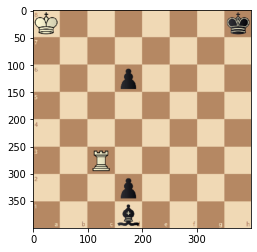

In [13]:
img_path = 'images/predictImage1.jpeg'
predictAndDisplaySingleNewImage(img_path,model)

In [19]:
testPath = "ChessImages/test/*.jpeg"
for imgList in image_generator(testPath,100):
    X_test,Y_test = getData(imgList)
    preds = model.evaluate(X_test, Y_test)
    print ("Loss = " + str(preds[0]))
    print ("Test Accuracy = " + str(preds[1]))

4/4 [==============================] - 1s 361ms/step - loss: 0.2285 - accuracy: 0.9573
Loss = 0.22846564650535583
Test Accuracy = 0.9573437571525574
4/4 [==============================] - 1s 362ms/step - loss: 0.2389 - accuracy: 0.9555
Loss = 0.23894427716732025
Test Accuracy = 0.9554687738418579
4/4 [==============================] - 1s 358ms/step - loss: 0.2062 - accuracy: 0.9638
Loss = 0.20623119175434113
Test Accuracy = 0.9637500047683716
4/4 [==============================] - 1s 364ms/step - loss: 0.2075 - accuracy: 0.9588
Loss = 0.2074989527463913
Test Accuracy = 0.9587500095367432
4/4 [==============================] - 1s 361ms/step - loss: 0.1988 - accuracy: 0.9611
Loss = 0.19883841276168823
Test Accuracy = 0.9610937237739563
4/4 [==============================] - 1s 361ms/step - loss: 0.2267 - accuracy: 0.9569
Loss = 0.22670738399028778
Test Accuracy = 0.9568750262260437
4/4 [==============================] - 1s 364ms/step - loss: 0.2183 - accuracy: 0.9580
Loss = 0.21832938492

4/4 [==============================] - 1s 358ms/step - loss: 0.2026 - accuracy: 0.9586
Loss = 0.20258952677249908
Test Accuracy = 0.9585937261581421
4/4 [==============================] - 1s 353ms/step - loss: 0.2139 - accuracy: 0.9581
Loss = 0.21391107141971588
Test Accuracy = 0.9581249952316284
4/4 [==============================] - 2s 376ms/step - loss: 0.2278 - accuracy: 0.9594
Loss = 0.2277688980102539
Test Accuracy = 0.9593750238418579
4/4 [==============================] - 1s 356ms/step - loss: 0.1966 - accuracy: 0.9597
Loss = 0.19662414491176605
Test Accuracy = 0.9596874713897705
4/4 [==============================] - 2s 376ms/step - loss: 0.1731 - accuracy: 0.9648
Loss = 0.1730666607618332
Test Accuracy = 0.96484375
4/4 [==============================] - 1s 361ms/step - loss: 0.2127 - accuracy: 0.9577
Loss = 0.2126912921667099
Test Accuracy = 0.9576562643051147
4/4 [==============================] - 1s 358ms/step - loss: 0.2131 - accuracy: 0.9580
Loss = 0.21307072043418884
Tes